In [1]:
from csv_psfs import *
import svd_model as svm

import forward_model as fm

import numpy as np
import scipy.io

# for a bit of investigation into the process surrounding the SVD
#import pdb
from IPython.core.debugger import set_trace

# load my own module for loading the PSFs
import sys
sys.path.append("../tensorflow")
import load_PSFs

In [2]:
import matplotlib as mpl
mpl.rc('image', cmap='inferno')
from matplotlib import pyplot as plt

# My SVD
Grab the PSF stack, do the SVD, test on the hydra. Simple as.

In [3]:
# psf_directory = "/home/dshteinbok/nV3_PSFs"
psf_directory = "../data/nV3_PSFs"
# psf_directory = "/home/dshteinbok/nV3_PSFs_flat"
#psf_directory = "/home/dshteinbok/nV3_PSFs_large"
# psf_meta = "/home/dshteinbok/nV3_PSFs_meta/PSF_Shifts.csv"
psf_meta = "../data/nV3_PSFs_flat_meta/metafile.csv"
# TODO: where to save

# (height, width)
#img_dims = (800, 1280)

# ACTUALLY should be (width, height) to be compatible with load_PSFs
img_dims = (1280, 800)
#img_dims = (1280, 1280)

In [4]:
psfs = load_from_dir(psf_directory, sort_psfs=True)

In [5]:
psfs.shape

(32, 32, 29)

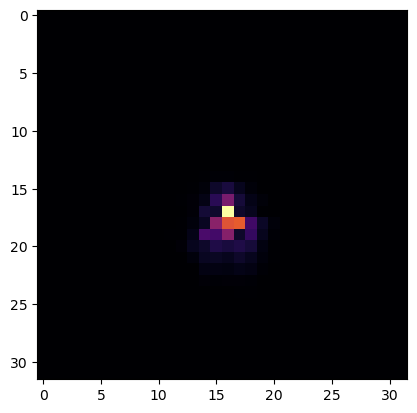

In [6]:
plt.imshow(psfs[:,:,1])

In [7]:
# load the PSFs
#psfs = pad_as_center(load_from_dir(psf_directory), img_dims[0], img_dims[1])

# psfs = np.flip(np.transpose(psfs, axes=(1,0,2)), (0,1))
psfs = np.flip(psfs, (0,1))
#psfs = np.transpose(psfs, axes=(1,0,2))

#psfs = pad_as_center(load_from_dir(psf_directory, sort_psfs=True), img_dims[1], img_dims[0])

#psfs = pad_as_center(psfs, img_dims[0], img_dims[1])
# psfs = np.swapaxes(pad_as_center(load_from_dir(psf_directory, sort_psfs=True), img_dims[1], img_dims[0]), 0,1)
#psfs = load_PSFs.load_PSFs_csv(psf_directory, psf_meta, img_dims)[:,:,:,0]

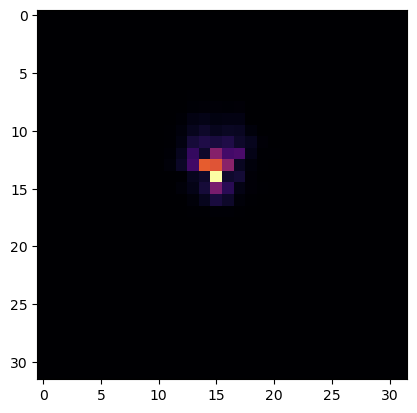

In [8]:
plt.imshow(psfs[:,:,1])

In [9]:
#psfs = pad_as_center(load_from_dir(psf_directory, sort_psfs=True), img_dims[1], img_dims[0])
psfs = np.transpose(psfs, axes=(1,0,2))

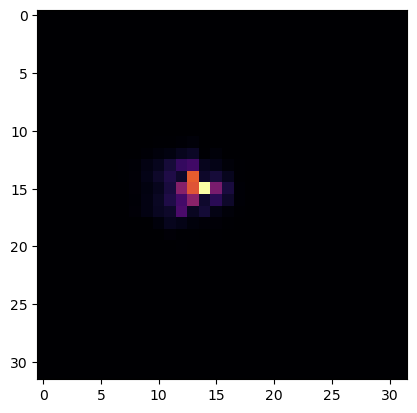

In [10]:
plt.imshow(psfs[:,:,1])

In [11]:
psfs = pad_as_center(psfs, img_dims[1], img_dims[0])

**ERROR DISCOVERED IN WALLER PAPER:** Waller et al. basically use the location of the brightest point in each of the PSFs to interpolate the PSF for all other points (specifically they interpolate the weights by which they must multiply each "kernel" for all points from the ones that they observe). However, they actually have all their PSFs centered in the frame, so all but one of their PSFs are in the center. The other PSF is (1,1) away from the center. Thus, all points within any quadrant exhibit shift-invariance.

To solve this, you need to be careful about how you pad your PSF. You don't want it to be in the center, but rather you want it shifted to wherever the light ends up.

In our case, according to the spec, this should be 1 pixel for every 0.8 um. 

In [12]:
ref_image_index=22
#set_trace()
psfs_reg,shifts=svm.register_psfs(psfs, psfs[:,:,ref_image_index],dct_on=False)

registering

done registering



In [13]:
shifts

{0: [1, 2],
 1: [1, 3],
 2: [1, 2],
 3: [0, 2],
 4: [0, 2],
 5: [0, 1],
 6: [0, 2],
 7: [2, 2],
 8: [1, 2],
 9: [2, 1],
 10: [2, 2],
 11: [1, 0],
 12: [1, -1],
 13: [1, 0],
 14: [0, 0],
 15: [0, 0],
 16: [0, 1],
 17: [0, 0],
 18: [2, 0],
 19: [1, 0],
 20: [2, 1],
 21: [2, 0],
 22: [1, 1],
 23: [2, 1],
 24: [2, 1],
 25: [2, 1],
 26: [0, 1],
 27: [0, 1],
 28: [0, 1]}

In [14]:
metaman = load_PSFs.MetaMan(psf_meta)

In [ ]:
rank=28
set_trace()
comps, weights_interp=svm.calc_svd(psfs_reg,metaman.shifts,rank)
#comps, weights_interp=svm.calc_svd(psfs_reg,shifts,rank)

--Return--
None
> /tmp/ipykernel_50349/2373792220.py(2)<cell line: 2>()
      1 rank=28
----> 2 set_trace()
      3 comps, weights_interp=svm.calc_svd(psfs_reg,metaman.shifts,rank)
      4 #comps, weights_interp=svm.calc_svd(psfs_reg,shifts,rank)

ipdb> b svd_model.py:131
Breakpoint 1 at /home/dshteinbok/MultiWienerNet/common/svd_model.py:131
ipdb> c
    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

creating matrix

done

starting svd...

check values of ymat
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(131)calc_svd()
    129 
    130     print('check values of ymat')
1-> 131     [u,s,v] = svds(ymat,rnk);
    132 
    133 

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(134)calc_svd()
    132 
    133 
--> 134     comps = np.reshape(u,[Ny, Nx,rnk],order='F');
    135     vt = v*1
    136     # s=np.flip(s)

ipdb> ps
*** NameError: name 'ps' is not defined
ipdb> p s
array([0.007

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(140)calc_svd()
    138     weights = np.zeros((Mgood,rnk));
    139     for m  in range (Mgood):
--> 140         for r in range(rnk):
    141             weights[m,r]=s[r]*vt[r,m]
    142 

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(141)calc_svd()
    139     for m  in range (Mgood):
    140         for r in range(rnk):
--> 141             weights[m,r]=s[r]*vt[r,m]
    142 
    143 

ipdb> p r
0
ipdb> p s[r]
0.0077127127834590815
ipdb> p s
array([0.00771271, 0.01030727, 0.01086703, 0.01135773, 0.01353782,
       0.01382475, 0.01545904, 0.01761762, 0.01825175, 0.02395615,
       0.02528276, 0.02943164, 0.03619661, 0.03736284, 0.0401677 ,
       0.04047083, 0.04589665, 0.04856169, 0.05473224, 0.06273703,
       0.06791324, 0.07970155, 0.08604391, 0.08784741, 0.12023425,
       0.1312615 , 0.15433901, 0.63159388])
ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(140)calc_svd()
    138     weights

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(152)calc_svd()
    150     xi=[]
    151     yi=[]
--> 152     si_list=list(si.values())
    153 
    154     for i in range(len(si_list)):

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(154)calc_svd()
    152     si_list=list(si.values())
    153 
--> 154     for i in range(len(si_list)):
    155         xi.append(si_list[i][0])
    156         yi.append(si_list[i][1])

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(155)calc_svd()
    153 
    154     for i in range(len(si_list)):
--> 155         xi.append(si_list[i][0])
    156         yi.append(si_list[i][1])
    157 

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(156)calc_svd()
    154     for i in range(len(si_list)):
    155         xi.append(si_list[i][0])
--> 156         yi.append(si_list[i][1])
    157 
    158     print('interpolating...\n')

ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(154)calc_svd()


ipdb> n
> /home/dshteinbok/MultiWienerNet/common/svd_model.py(163)calc_svd()
    161     #     weights_interp(:,:,r) = rot90(interpolant_r(Xq,Yq),2);
    162         # BELOW IS WRONG: should be (y,x) rather than (x,y)
--> 163         weights_interp[:,:,r]=griddata((xi,yi),weights[:,r],(Xq,Yq),method=method)
    164         #weights_interp[:,:,r]=griddata((yi,xi),weights[:,r],(Yq,Xq),method=method)
    165 

ipdb> b svd_model.py:168
Breakpoint 4 at /home/dshteinbok/MultiWienerNet/common/svd_model.py:168
ipdb> c
done


> /home/dshteinbok/MultiWienerNet/common/svd_model.py(168)calc_svd()
    166     print('done\n\n')
    167 
4-> 168     return np.flip(comps,-1), np.flip(weights_interp,-1)
    169 
    170 def calc_svd_shiftlist(yi_reg,si_list,rnk,method='nearest'):

ipdb> p weights_interp[0,0,0]
0.0033511374974985477
ipdb> p weights_interp[0,0,27]
-0.08033262530946585


In [ ]:
weights_interp.shape

In [ ]:
metaman.shifts

In [ ]:
# Normalize weights to have maximum sum through rank of 1
# first, np.sum returns a scalar. Second, this norm happens to be a negative scalar which flips the values of the PSFs
# hence I negate the negative
# weights_norm = np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0).max()
weights_norm = np.absolute(np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0).max())
weights = weights_interp/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=comps/np.linalg.norm(np.ravel(comps))

In [ ]:
weights_norm

In [ ]:
np.linalg.norm(np.ravel(comps))

In [ ]:
plt.imshow(np.sum(weights, -1))
plt.colorbar()

In [ ]:
plt.imshow(np.sum(h, -1))
plt.colorbar()

In [ ]:
h.shape

In [ ]:
weights.shape

In [ ]:
# h_dict = {"array_out": h}
# scipy.io.savemat("../data/nV3_h.mat", h_dict)
# #scipy.io.savemat("../data/nV3_h_exagg.mat", h_dict)

In [ ]:
# weights_dict = {"array_out": weights}
# scipy.io.savemat("../data/nV3_weights.mat", weights_dict)
# #scipy.io.savemat("../data/nV3_weights_exagg.mat", weights_dict)

Now, view each of the PSFs at the 12 positions:

In [ ]:
psfs_reg.shape

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 5, figsize=(15,15))
for row in range(5):
    for column in range(5):
        axs[row, column].imshow(psfs_reg[372:432,610:670,row*4 + column])
        #axs[row, column].imshow(np.swapaxes(psfs_reg[372:432,610:670,row*4 + column], 0,1))
        #axs[row, column].imshow(np.flip(np.transpose(psfs_reg[372:432,610:670,row*4 + column], axes=(1,0)), (0,1)))
        axs[row,column].set_title(metaman.shifts[row*4 + column+1])
        print(np.unravel_index(np.argmax(psfs_reg[:,:,row*4]), (800,1280)))

In [ ]:
h.shape

In [ ]:
weights.shape

In [ ]:
plt.imshow(np.sum(h*weights[649,633,:] , -1)[372:432,610:670])
plt.colorbar()